# Bayesian Forecaster

#### Imports

In [140]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

#### data setup

In [356]:
# importing data
experiment_type = "small"
data_directory = '../data/experiment_' + experiment_type + '/'
data = np.load(data_directory + 'network_params/data_network.npy')
data = np.transpose(data, (2,1, 0))

#reshaping and trimming
data = data.reshape(len(data),2*len(data[0]))
data_test = data[-365:,:]
data_val = data[-3*365:-365,:]
data_train = data[:-3*365,:]

diffs_test = np.diff(data_test, axis=0)
diffs_val = np.diff(data_val, axis=0)
diffs_train = np.diff(data_train, axis=0)

T,D = diffs_train.shape

# creating the dataframe
hospital_list = np.genfromtxt(data_directory + 'network_params/hospitals.txt', dtype=str, delimiter='\n', comments=None)
df_cols = np.array([[h + ' supply',h + ' demand'] for h in hospital_list]).reshape(D)
df = pd.DataFrame(diffs_train, columns=df_cols)

df

,Orange County supply,Orange County demand,Los Angeles supply,Los Angeles demand,Alta Bates supply,Alta Bates demand,Oakland supply,Oakland demand
0,-0.822526,4.916822,-0.651468,5.990946,-0.181573,1.195645,-0.153877,0.551387
1,-5.102420,-2.577938,-5.759107,-3.141480,-1.605124,-0.864180,-0.954659,-0.499657
2,-6.269205,-12.057078,-7.188447,-14.690660,-2.003511,-3.462579,-1.172944,-1.826633
3,0.079720,2.358417,0.267309,2.874134,0.074500,0.414624,0.014919,0.172501
4,-1.913910,-2.842920,-2.149450,-3.464546,-0.599088,-1.026598,-0.358112,-0.558890
...,...,...,...,...,...,...,...,...
1700,-4.477227,2.448968,-4.135527,3.899951,-1.152622,1.052343,-0.427141,0.540418
1701,0.916913,-12.227958,2.282668,-13.954272,0.636207,-2.929913,0.593405,-1.504606
1702,-0.431906,-0.849498,0.724342,-0.062672,0.201877,0.149546,0.350260,0.076791
1703,-0.229383,-6.185178,1.000272,-6.537077,0.278795,-1.301809,0.395280,-0.668523


#### constructing the BVAR model

In [355]:
def bvar_model(h,df,priors,draws=2000,tune=1000,chains=4,cores=4):
    coords = {
        "lags": np.arange(h)+1,
        "vars": df.columns.tolist(),
        "eqs": df.columns.tolist(),
        "time": [t for t in df.index[h:]]
    }

    with pm.Model(coords=coords) as model:
        # variable setup
        beta = pm.Normal(
            "beta",
            mu=priors["beta"]["mu"],
            sigma=priors["beta"]["sigma"],
            dims=("lags","eqs","vars")
        )
        alpha = pm.Normal(
            "alpha",
            mu=priors["alpha"]["mu"],
            sigma=priors["alpha"]["sigma"],
            dims=("eqs",)
        )
        data_obs = pm.Data(
            "data_obs",
            df.values[h:], 
            dims=("time","eqs"),
        )

        n = df.shape[1]

        # ar step
        ar = []
        for i in range(n):
            ar_i = pm.math.sum([
                pm.math.sum(beta[t,i] * df.values[h-(t+1):-(t+1)],axis=-1)
                for t in range(h)
            ],axis=0)
            ar.append(ar_i)

        mu = alpha + pm.math.stack(ar, axis=-1)
        sigma = pm.HalfNormal(
            "noise",
            sigma=priors["noise"]["sigma"],
            dims=["eqs"]
        )
        obs = pm.Normal(
            "obs",
            mu=mu,
            sigma=sigma,
            observed=data_obs,
            dims=["time","eqs"]
            )

        #sampling
        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            cores=cores,
            random_seed=420,
            target_accept=0.95,
            sample='blackjax'
        )
    return model,trace

In [152]:
h = 7
draws=8000
tune=8000
chains=4
cores=4

priors = {
    "beta": {"mu": 0.0, "sigma": 10.0},
    "alpha": {"mu": 0.0, "sigma": 10.0},
    "noise": {"sigma": 10.0}
}

model, trace = bvar_model(h, df, priors,draws=draws,tune=tune,chains=chains,cores=cores)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12325 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### looking at the model

In [155]:
az.summary(trace, var_names=["alpha", "beta","noise"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[Orange County supply],-0.076,0.154,-0.329,0.240,0.026,0.018,36.0,130.0,1.10
alpha[Orange County demand],-0.000,0.163,-0.295,0.309,0.015,0.011,116.0,189.0,1.03
alpha[Los Angeles supply],-0.014,0.152,-0.269,0.287,0.017,0.012,78.0,252.0,1.04
alpha[Los Angeles demand],-0.049,0.162,-0.365,0.226,0.022,0.016,54.0,213.0,1.03
alpha[Alta Bates supply],-0.006,0.046,-0.096,0.084,0.009,0.006,30.0,66.0,1.11
...,...,...,...,...,...,...,...,...,...
noise[Los Angeles demand],6.303,0.105,6.113,6.500,0.022,0.016,23.0,89.0,1.14
noise[Alta Bates supply],1.842,0.029,1.786,1.900,0.005,0.003,38.0,73.0,1.09
noise[Alta Bates demand],1.631,0.031,1.576,1.690,0.005,0.004,34.0,146.0,1.09
noise[Oakland supply],0.844,0.014,0.817,0.871,0.001,0.001,115.0,171.0,1.02


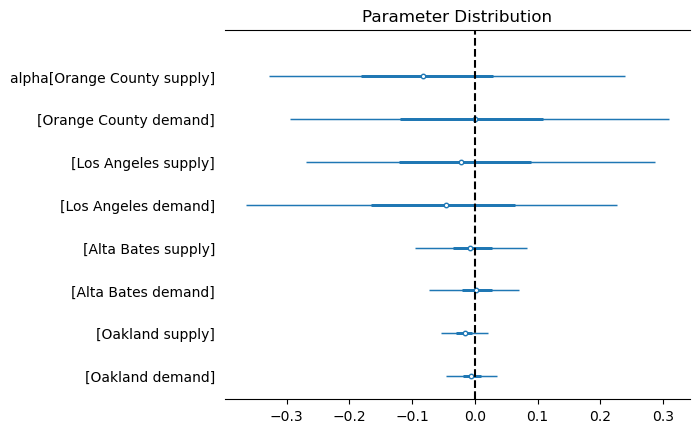

In [374]:
#fig, ax = plt.subplots(figsize=(20, 100))
az.plot_forest(trace, var_names=["alpha"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Parameter Distribution");

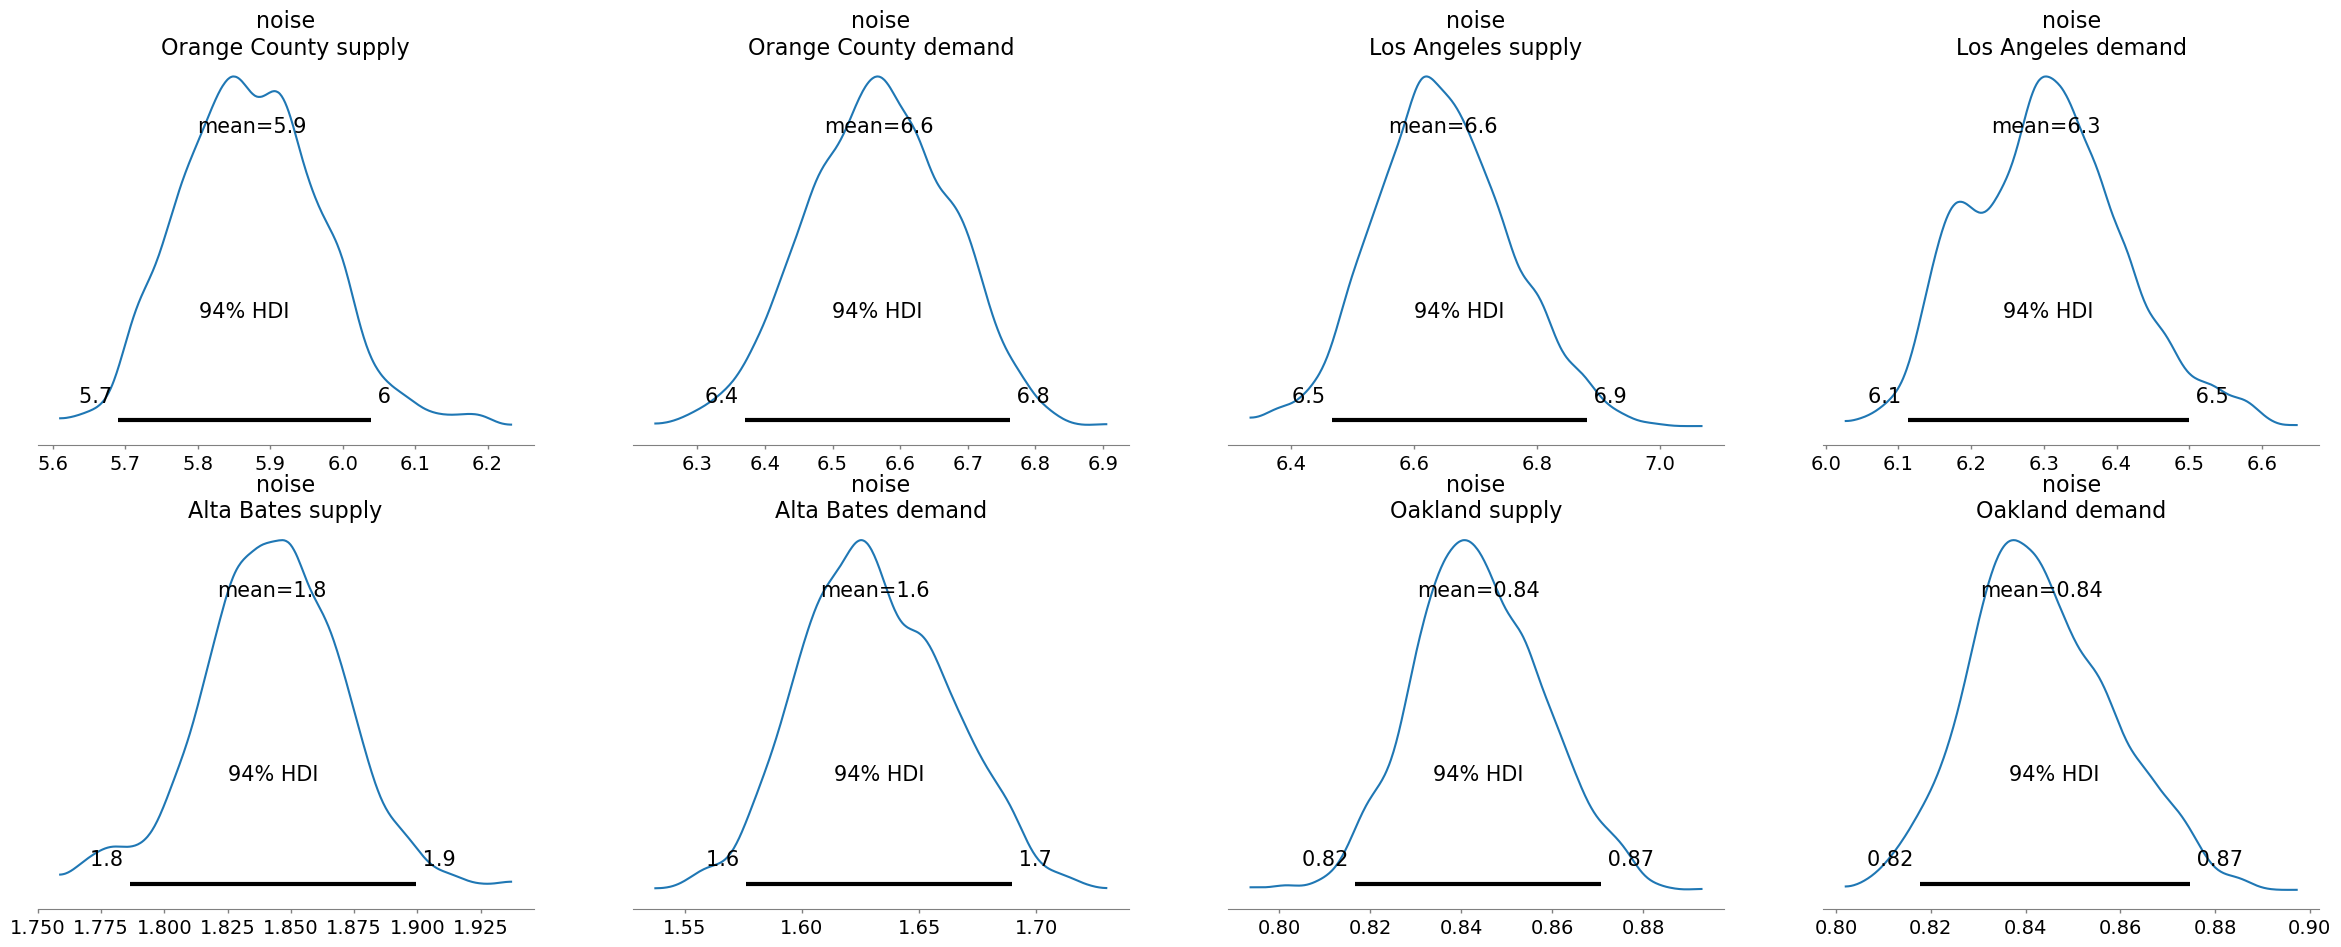

In [375]:
az.plot_posterior(trace, var_names=["noise"]);

#### forecasting

In [422]:
def _forecast(data,alpha,beta,noise,f):
    len_data = len(data)
    h = len(beta)
    data_forecast = np.zeros((data.shape[0]+f,data.shape[1]))
    data_forecast[:len_data] = data[:]

    for t in range(f):
        ar = []
        for n in range(data.shape[1]):
            ar_n = np.sum(beta[:,n]*data_forecast[len_data+t-h:len_data+t])
            ar.append(ar_n)
        mu = alpha + np.stack(ar,axis=-1)
        data_forecast[len_data+t] = np.random.normal(mu,noise)
    data_forecast[:-f-1] = np.nan
    return data_forecast

forecast = np.vectorize(
    _forecast,
    signature=("(T,D),(D),(H,D,D),(D)->(F,D)"),
    excluded=("f"),
)

In [423]:
size = 200
sample_indices = np.random.randint(draws*chains,size=size)
post = trace.posterior.stack(sample=("chain","draw"))
alpha_draws = post["alpha"].values.T[sample_indices]
beta_draws = post["beta"].values.T[sample_indices].T
beta_draws = np.moveaxis(beta_draws,-1,0)
noise_draws = post["noise"].values.T[sample_indices]

In [428]:
f=3
forecast_draws = forecast(diffs_train,alpha_draws,beta_draws,noise_draws,f=f)

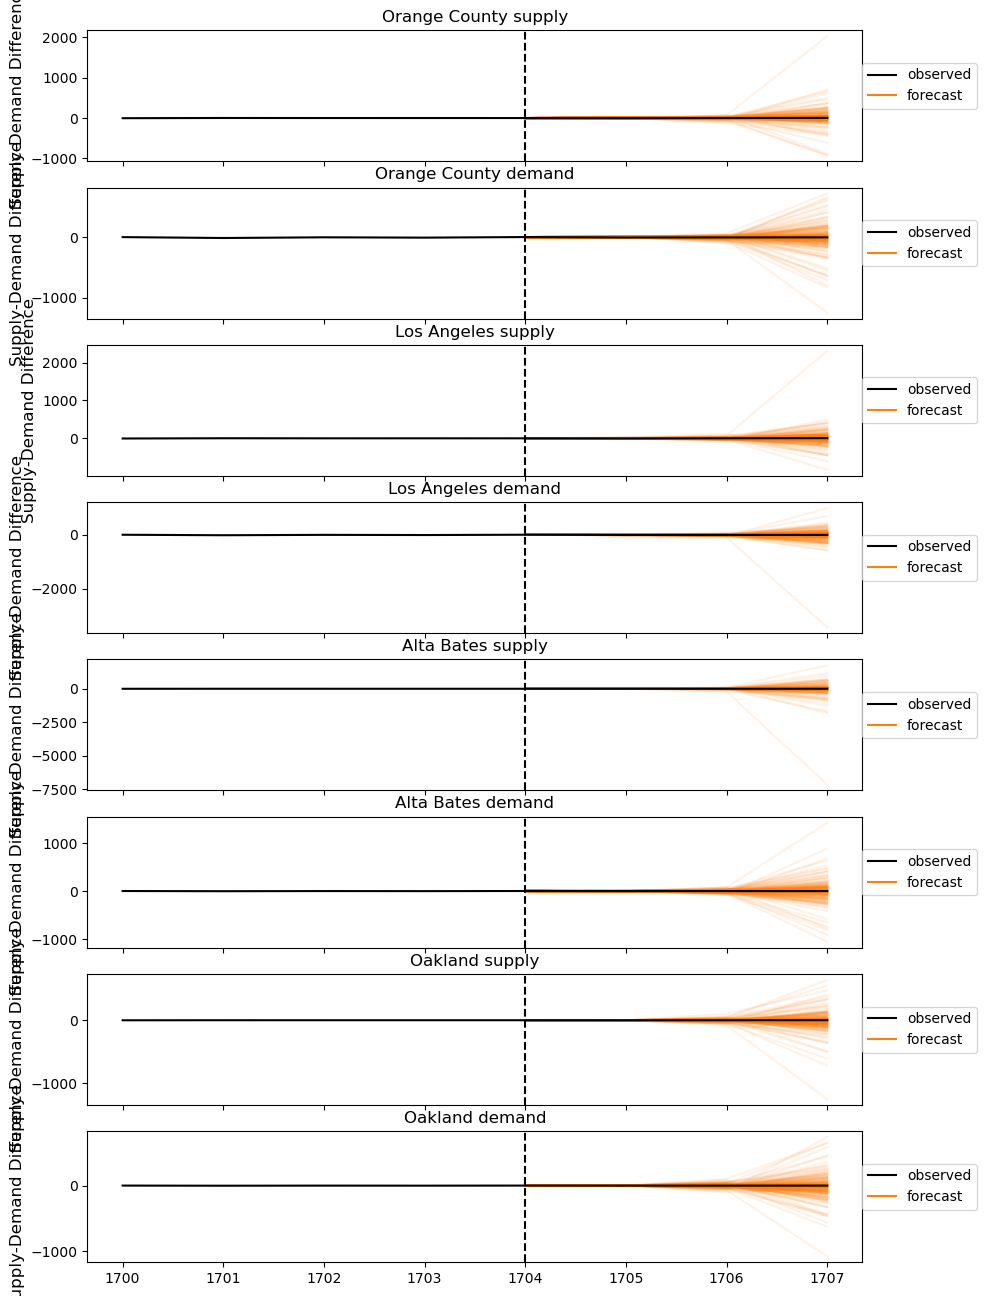

In [430]:
_, ax = plt.subplots(D, 1, sharex=True,figsize=(10, 2 * D))
times = np.arange(len(diffs_train)+f)
diff = np.diff(data, axis=0)
stagger = 1700

for n in range(D):
    ax[n].set_title(df_cols[n])

    for i in range(size):
            ax[n].plot(times[stagger:], forecast_draws[i,stagger:,n], color="C1", alpha=0.1)

    #ax[n].set_ylim(-50, 50)
    ax[n].plot(times[stagger:],diff[stagger:len(diffs_train)+f,n], color="k", label="observed")
    ax[n].plot([], color="C1", label="forecast")

for axi in ax:
    axi.axvline(len(times)-f-1, ls="--", color="k")
    axi.legend(fontsize=10, loc=(1, .4))
    axi.set_ylabel("Supply-Demand Difference", fontsize=12)

In [311]:
trace.to_netcdf('trace.nc')

'trace.nc'

In [413]:
def get_bayesian_forecast(trace,history,sample_size=100,draws=1000,chains=4,f=3):
    sample_indices = np.random.randint(draws*chains,size=size)
    post = trace.posterior.stack(sample=("chain","draw"))
    alpha_draws = post["alpha"].values.T[sample_indices]
    beta_draws = post["beta"].values.T[sample_indices].T
    beta_draws = np.moveaxis(beta_draws,-1,0)
    noise_draws = post["noise"].values.T[sample_indices]

    N,T,_ = history.shape
    history_resh = history.transpose(1,0,2).reshape(T,2*N)

    forecast_draws = forecast(history_resh,alpha_draws,beta_draws,noise_draws,f=f)
    forecast_draws = forecast_draws[:,-f:,:]
    return forecast_draws.reshape(forecast_draws.shape[0],forecast_draws.shape[1],forecast_draws.shape[2]//2,2).transpose(0,2,1,3)

In [415]:
history = diffs_test[-h:,:]
history = history.reshape(h,history.shape[1]//2,2).transpose(1,0,2)

test = get_bayesian_forecast(trace,history,f=f)
print(test.shape)

(200, 4, 3, 2)
